In [1]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd

from tensorflow import set_random_seed
import operator

import matplotlib.pyplot as plt

import pickle
import time
import gc
import random

from sklearn.metrics import f1_score,accuracy_score
from   sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from   keras import initializers, regularizers, constraints, callbacks, optimizers
from keras.layers import Conv1D, Embedding, GlobalMaxPooling1D, concatenate, Input, Dense,add, concatenate
from keras.layers import SpatialDropout1D,CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from   keras.models import Sequential, Model
from   keras.preprocessing.sequence import pad_sequences
from   keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spacy.lang.en import English
nlp = English()

Using TensorFlow backend.


In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    set_random_seed(seed)
    
seed_everything()

In [3]:
train = pd.read_csv("../input/innoplex/train.csv")
test = pd.read_csv("../input/innoplex/test.csv")

In [4]:
train['sentiment'].value_counts()

2    3825
1     837
0     617
Name: sentiment, dtype: int64

In [5]:
train.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [6]:
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(train['sentiment']) ,train['sentiment'])

In [7]:
labels = pd.get_dummies(train['sentiment']).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (5279, 3)


In [8]:
train = train.drop(['sentiment'],axis=1)

In [9]:
9# GLOVE_FILE
GLOVE_EMBEDDING_PATH = '../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'

# WORD-level
MAX_NUM_WORDS     = 15000
EMBEDDING_DIM     = 300
MAX_SEQ_LENGTH    = 120
USE_GLOVE         = True


# GENERAL
DROPOUT_RATE      = 0.4
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 2 * LSTM_UNITS
NB_CLASSES        = 3

# LEARNING
BATCH_SIZE        = 512
NB_EPOCHS         = 10
RUNS              = 2
VAL_SIZE          = 0.2

In [10]:
# function to clean data

def cleanData(doc,stemming = False):
    doc = doc.lower()
    doc = nlp(doc)
    
    tokens = [tokens.lower_ for tokens in doc]
    tokens = [tokens for tokens in doc if (tokens.is_stop == False)]
    final_tokens = [tokens for tokens in tokens if (tokens.is_punct == False)]
    final_token = [token.lemma_ for token in tokens]
    
    return " ".join(final_token)

In [11]:
# clean description
train['text'] = train['text'].map(lambda x: cleanData(x))
# clean description
test['text'] = test['text'].map(lambda x: cleanData(x))

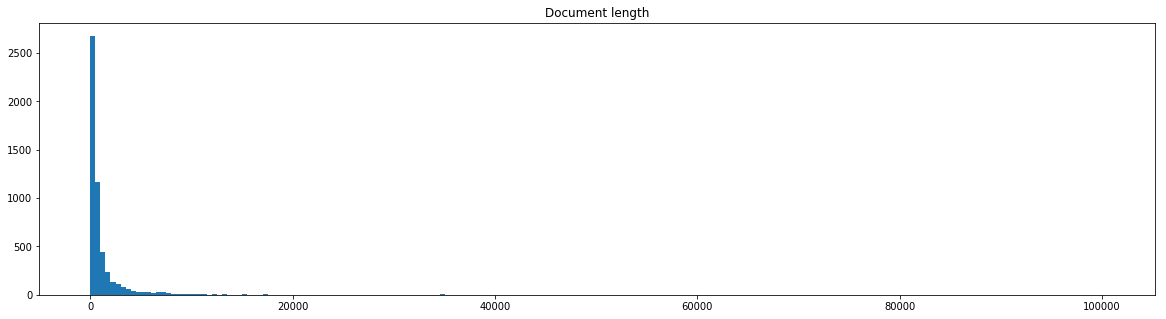

Text informations:
max length: 100269 / min length: 7 / mean length: 1426 / limit length: 120
vacobulary size: 41075 / limit: 15000


In [12]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(list(train['text'])+ list(test['text']))

sequences_train = tokenizer.texts_to_sequences(train['text'])
sequences_test = tokenizer.texts_to_sequences(test['text'])

drug_feature_train = pd.get_dummies(train['drug']).values
drug_feature_test = pd.get_dummies(test['drug']).values

word_index = tokenizer.word_index

# get the length of the string of column in a dataframe
 
result = [len(x) for x in train['text'].values.tolist()]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = pad_sequences(sequences_train, maxlen=MAX_SEQ_LENGTH, padding='post')

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data_test = pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

In [13]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        
        try:
            embedding_vector = embedding_index[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except:
            pass

    return embedding_matrix

In [14]:
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [15]:
# tic = time.time()
# glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
# print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

In [16]:
# vocab = build_vocab(list(train['text'].apply(lambda x:x.split())))
# oov = check_coverage(vocab,glove_embeddings)
# oov[:10]

In [17]:
def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=True)(words)
    x = SpatialDropout1D(DROPOUT_RATE)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    hidden = GlobalMaxPooling1D()(x)
    hidden = Dense(DENSE_HIDDEN_UNITS,activation='relu')(hidden)
    result = Dense(NB_CLASSES, activation='softmax')(hidden)
    
    model = Model(inputs = words,outputs = result)
    model.compile(loss='categorical_crossentropy',
        optimizer=Adam(1e-3, clipnorm=1.),
        metrics=['accuracy'])

    return model

In [18]:
embedding_matrix = build_matrix(word_index,GLOVE_EMBEDDING_PATH)

In [19]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE('minority')

X_train, X_val, y_train, y_val = train_test_split(word_data, labels, stratify=labels,test_size=VAL_SIZE)
X_sm, y_sm = smote.fit_sample(word_data, labels)
print(X_sm.shape, y_sm.shape)

(8487, 120) (8487, 3)


In [20]:
word_data

array([[ 886,    5, 1236, ...,    0,    0,    0],
       [ 742,  303,  114, ...,    0,    0,    0],
       [ 505,  150, 3013, ...,    0,    0,    0],
       ...,
       [  36,  775,  322, ...,    0,    0,    0],
       [ 180, 2972,   90, ...,    0,    0,    0],
       [   7,  465,  723, ...,    0,    0,    0]], dtype=int32)

In [21]:
histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    random_state = np.random.randint(1000)
    
    model = build_model(embedding_matrix, NB_CLASSES)
                  
    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,class_weight=class_weight,
        validation_data=(X_val, y_val),callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.0001)])
    
    histories.append(history.history)

Running iteration 1/2
Train on 4223 samples, validate on 1056 samples
Epoch 1/10
4223/4223 [==============================] - 5s 1ms/step - loss: 0.8174 - acc: 0.7113 - val_loss: 0.7670 - val_acc: 0.7244
Epoch 2/10
4223/4223 [==============================] - 1s 141us/step - loss: 0.7535 - acc: 0.7246 - val_loss: 0.7740 - val_acc: 0.7263
Epoch 3/10
4223/4223 [==============================] - 1s 141us/step - loss: 0.7407 - acc: 0.7248 - val_loss: 0.7510 - val_acc: 0.7311
Epoch 4/10
4223/4223 [==============================] - 1s 139us/step - loss: 0.7191 - acc: 0.7251 - val_loss: 0.7174 - val_acc: 0.7292
Epoch 5/10
4223/4223 [==============================] - 1s 139us/step - loss: 0.6989 - acc: 0.7284 - val_loss: 0.7181 - val_acc: 0.7131
Epoch 6/10
4223/4223 [==============================] - 1s 140us/step - loss: 0.6869 - acc: 0.7293 - val_loss: 0.7275 - val_acc: 0.6894
Running iteration 2/2
Train on 4223 samples, validate on 1056 samples
Epoch 1/10
4223/4223 [========================

In [22]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc'   % (get_avg(histories, 'loss'),
                                                get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	0.6669 loss / 0.7376 acc
Validation: 	0.7030 loss / 0.7273 acc


In [23]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

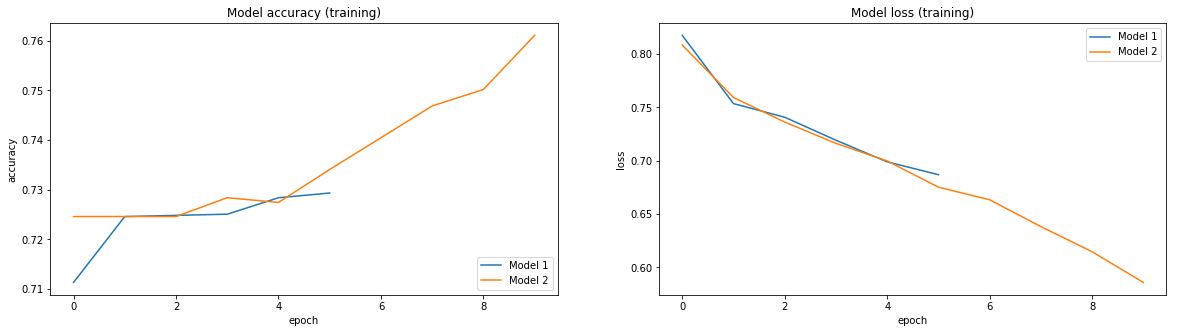

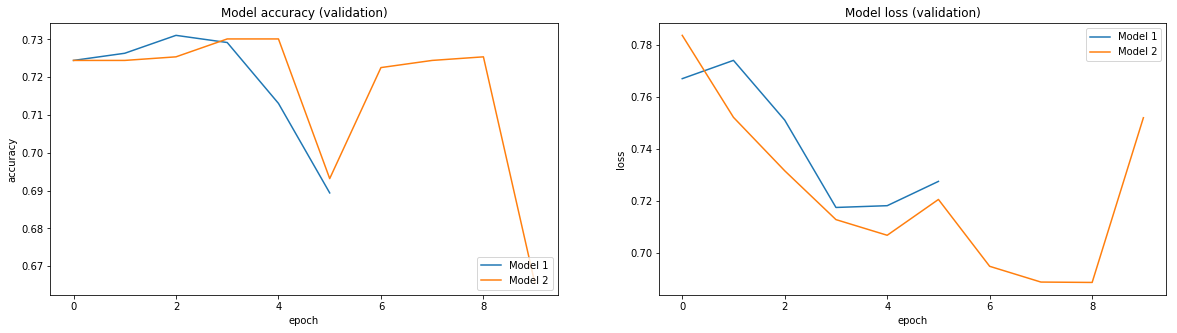

In [24]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

In [25]:
preds = model.predict(word_data_test)

In [26]:
preds1 = np.argmax(preds, axis=1)

In [27]:
sub1 = pd.DataFrame({'unique_hash':test.unique_hash, 'sentiment':preds1})

In [28]:
sub1['sentiment'].value_counts()

2    2203
0     362
1     359
Name: sentiment, dtype: int64

In [29]:
## write submission files
sub1.to_csv('submission3.csv', index=False)